In [5]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from u2net import U2NET, U2NETP

In [6]:

def load_u2net(model_path="u2net.pth"):
    net = U2NET(3, 1)
    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_path))
        net.cuda()
    else:
        net.load_state_dict(torch.load(model_path, map_location="cpu"))
    net.eval()
    return net


def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path).convert("RGB")
    return transform(image).unsqueeze(0), image

def segment_leaf_u2net(img_path, model):
    tensor_img, orig_image = preprocess_image(img_path)
    if torch.cuda.is_available():
        tensor_img = tensor_img.cuda()

    with torch.no_grad():
        d1, _, _, _, _, _, _ = model(tensor_img)
        pred = d1[:, 0, :, :]
        pred = (pred - pred.min()) / (pred.max() - pred.min())

    mask = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
    mask = cv2.resize(mask, orig_image.size)
    _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)


    image = np.array(orig_image)
    segmented = cv2.bitwise_and(image, image, mask=mask)

    return segmented, mask

def refine_mask_with_color(image, mask):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_green = np.array([22, 30, 30]) 
    upper_green = np.array([88, 255, 255])


    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    refined_mask = cv2.bitwise_and(mask, mask, mask=green_mask)
    return refined_mask

In [ ]:
model = load_u2net("u2net.pth")
input_folder = "test"

output_folder = "segmented"
os.makedirs(output_folder, exist_ok=True)

for fname in os.listdir(input_folder):
    if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(input_folder, fname)
    segmented, mask = segment_leaf_u2net(img_path, model)

    # 🔹 Only green filter
    refined_mask = refine_mask_with_color(segmented, mask)
    final_segmented = cv2.bitwise_and(segmented, segmented, mask=refined_mask)

    # final_segmented = segmented

    save_path = os.path.join(output_folder, fname)
    cv2.imwrite(save_path, cv2.cvtColor(final_segmented, cv2.COLOR_RGB2BGR))

    print(f"Processed: {fname}")

C:\Users\abhij\AppData\Local\Temp\ipykernel_31832\1825010050.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path))


Processed: IMG_0425.JPG
Processed: IMG_0461.JPG
Processed: IMG_0462.JPG
Processed: IMG_0471.JPG
Processed: test1.JPG
Processed: test2.JPG


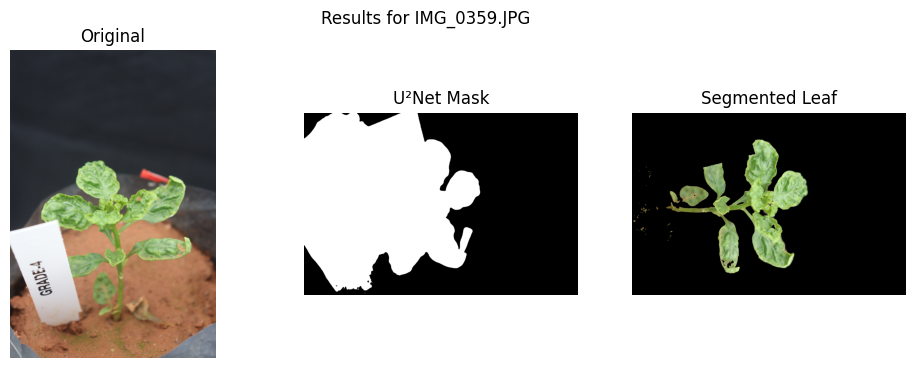

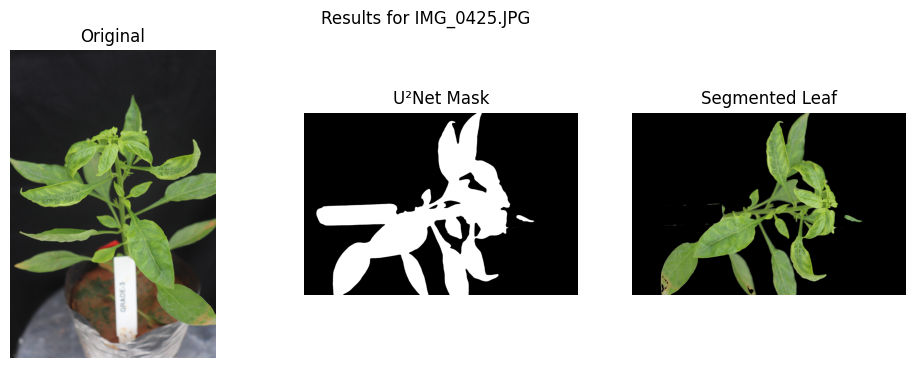

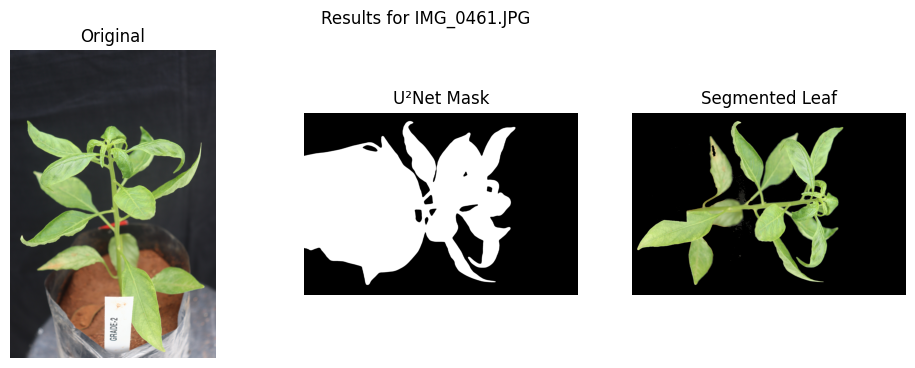

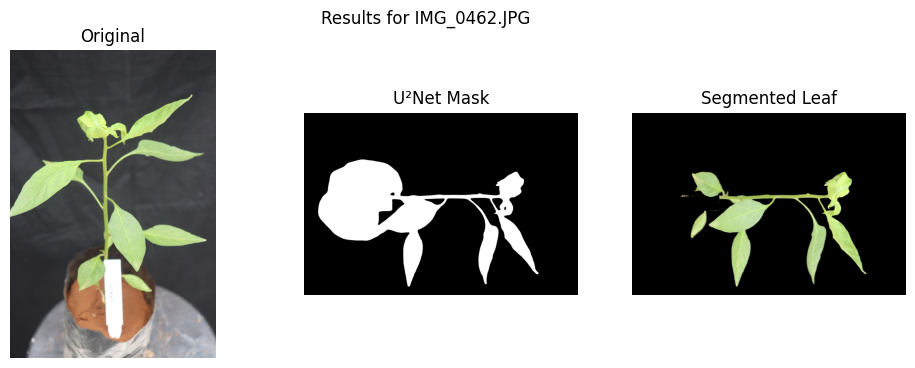

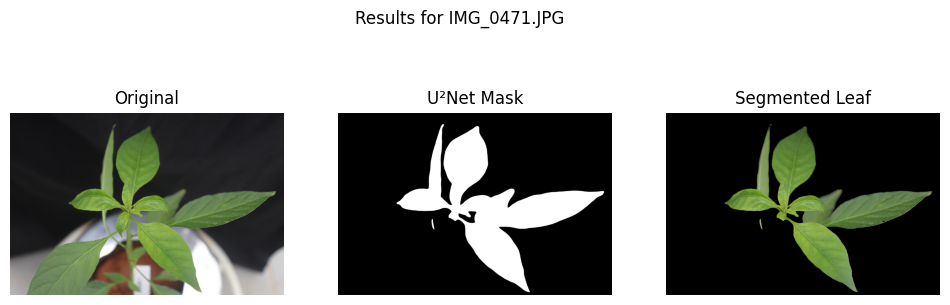

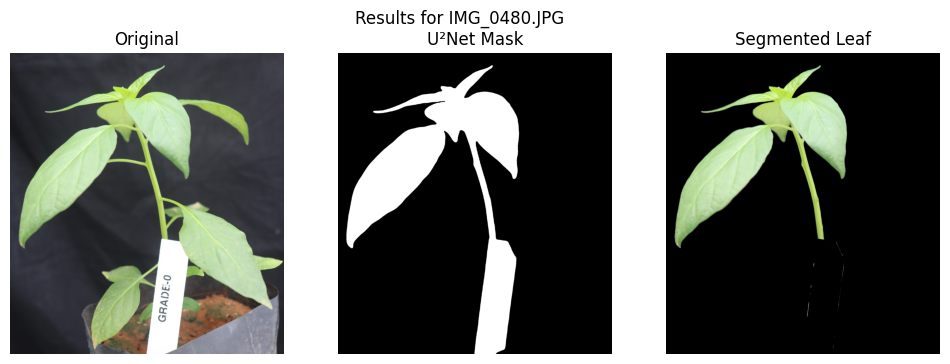

In [4]:
for fname in os.listdir(input_folder):
    if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(input_folder, fname)
    segmented, mask = segment_leaf_u2net(img_path, model)

    # 🔹 Only green filter, no largest component
    refined_mask = refine_mask_with_color(segmented, mask)
    final_segmented = cv2.bitwise_and(segmented, segmented, mask=refined_mask)

    # Load original image for plotting
    orig = cv2.imread(img_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("U²Net Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(final_segmented)
    plt.title("Segmented Leaf")
    plt.axis("off")

    plt.suptitle(f"Results for {fname}")
    plt.show()